In [1]:
import os
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Reading the data

* Source: `http://ai.stanford.edu/~amaas/data/sentiment/`
* Reading the data from `train` folder
* The data has been segregated into `pos` and `neg` folders (only these two folders are considered here!)
* The data to be read are `.txt` files
* Data read from each `.txt` file is appended to a list `texts` and the corresponding label is appended to `labels` list in the same order

In [10]:
# Source: http://ai.stanford.edu/~amaas/data/sentiment/

imdb_path = os.getcwd() + '/data/aclImdb_v1/aclImdb'

training_dir_path = os.path.join(imdb_path,'train')
testing_dir_path = os.path.join(imdb_path,'test')

def read_data(path):
    
    texts = []
    labels = []
    
    for label_type in ['pos','neg']:
        sub_dir_path = os.path.join(training_dir_path,label_type)
        sub_dirs = os.listdir(sub_dir_path)
        for sub_dir in sub_dirs:
            if sub_dir[-4:] == '.txt':
                f = open(os.path.join(sub_dir_path,sub_dir))
                texts.append(f.read())
                f.close()
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)
    return texts, labels
        
texts, labels = read_data(training_dir_path)
test_texts, test_labels = read_data(testing_dir_path)

print('Successfully read {0} texts from training data!'.format(len(texts)))
print('Successfully read {0} texts from testing data!'.format(len(test_texts)))

print('\n\nSample raw text from the data: \n\n{0}'.format(texts[10]))

Successfully read 25000 texts from training data!
Successfully read 25000 texts from testing data!


Sample raw text from the data: 

I love this movie and never get tired of watching. The music in it is great. Any true hard rock fan should see this movie and buy the soundtrack. With rockers like Gene Simmons and Ozzy Osbourne you can't go wrong.


### Tokenizing the text and preparing training/validation data

* Using `Tokenizer` from `keras.preprocessing.text` to fit the texts and produce sequences out of them
* Using `pad_sequences` from `keras.preprocessing.sequence` to pad the sequences to uniform length
* Split the data into `training` and `validation` set by shuffling the indices

In [12]:
MAX_WORDS = 10000
MAX_LEN = 100
TRAIN_SIZE = 16000
VALIDATION_SIZE = 4000

tokenizer = Tokenizer(num_words=MAX_WORDS)

def prepare_data(texts, tokenizer):
    
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    data = pad_sequences(sequences,maxlen=MAX_LEN)
    
    print('Found {0} unique tokens!'.format(len(tokenizer.word_index)))
    print('Data dimensions: {0}'.format(data.shape))

    return data

data = prepare_data(texts, tokenizer)
test_data = prepare_data(test_texts, tokenizer)

print('\n Sample processed data (using tokenizer word indexes 1-9999): \n\n{0}'.format(data[10]))

labels = np.asarray(labels)
test_labels = np.asarray(test_labels)

indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)

data = data[indexes]
labels = labels[indexes]

X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE: TRAIN_SIZE+VALIDATION_SIZE]

y_train = labels[:TRAIN_SIZE]
y_val = labels[TRAIN_SIZE:TRAIN_SIZE+VALIDATION_SIZE]

print('\n\nTraining set size: {0}, validation set size: {1}, Test set size: {2}'.format(X_train.shape[0], X_val.shape[0], test_data.shape[0]))

Found 88582 unique tokens!
Data dimensions: (25000, 100)
Found 88582 unique tokens!
Data dimensions: (25000, 100)

 Sample processed data (using tokenizer word indexes 1-9999): 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   10  116   11   17    2  112   76 1454
    4  146    1  225    8    9    6   84   98  280  251  737  334  141
   64   11   17    2  816    1  812   16   37 1921 5175    2   22  188
  137  352]


Training set size: 16000, validation set size: 4000, Test set size: 25000


### Pre-trained word vectors

* Glove vectors are read from the downloaded location (source: `https://nlp.stanford.edu/projects/glove`)
* Building an `embedding_index` that maps words from Glove to their word vectors
* The `embedding_matrix` is prepared based on the `word_indexes` provided by the `tokenizer` using 100-d word vectors defined in `embedding_index`
* This `embedding_matrix` would be fed to the `Embedding` layer weights and kept frozen


#### Note on word vectors
* --pending


In [13]:
embedding_index = {}

glove_path = os.getcwd() + '/data/glove.6B/glove.6B.100d.txt' # Using 100-dimensional word vectors
f = open(glove_path)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs
    
f.close()

print('Found {0} word vectors!'.format(len(embedding_index)))

# Defining the embedding_matrix to be fed to Embedding layer of the Model

EMBEDDING_DIM = 100

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

for word,index in tokenizer.word_index.items():
    if index < MAX_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector # Otherwise, it remains as zeros

print('Embedding matrix of shape {0} prepared. To be fed to the Embedding layer weights.'.format(embedding_matrix.shape))

Found 400000 word vectors!
Embedding matrix of shape (10000, 100) prepared. To be fed to the Embedding layer weights.


### Building and training the model

* `Embedding` layer is loaded with weights from `embedding_matrix` and is frozen by setting `trainable` to `False`

In [14]:
model = Sequential()

model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN, name='embedding_1'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Loading Glove embeddings to the model
model.get_layer('embedding_1').set_weights([embedding_matrix])
model.get_layer('embedding_1').trainable = False

# model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [15]:
EPOCHS = 8
BATCH_SIZE = 64

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

model.save_weights('data/6.1.3_IMDB_sentiment_analysis_from_scratch_v1.h5')

Train on 16000 samples, validate on 4000 samples
Epoch 1/8
16000/16000 [==============================] - 3s 207us/step - loss: 0.7242 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.4975
Epoch 2/8
16000/16000 [==============================] - 3s 190us/step - loss: 0.6942 - acc: 0.5042 - val_loss: 0.6940 - val_acc: 0.5020
Epoch 3/8
16000/16000 [==============================] - 3s 176us/step - loss: 0.6953 - acc: 0.5200 - val_loss: 0.6987 - val_acc: 0.5082
Epoch 4/8
16000/16000 [==============================] - 4s 243us/step - loss: 0.6778 - acc: 0.5564 - val_loss: 0.7017 - val_acc: 0.5100
Epoch 5/8
16000/16000 [==============================] - 5s 298us/step - loss: 0.6570 - acc: 0.5881 - val_loss: 0.7216 - val_acc: 0.5180
Epoch 6/8
16000/16000 [==============================] - 5s 310us/step - loss: 0.6218 - acc: 0.6269 - val_loss: 0.7660 - val_acc: 0.5095
Epoch 7/8
16000/16000 [==============================] - 5s 318us/step - loss: 0.5837 - acc: 0.6598 - val_loss: 0.7377 - val_acc:

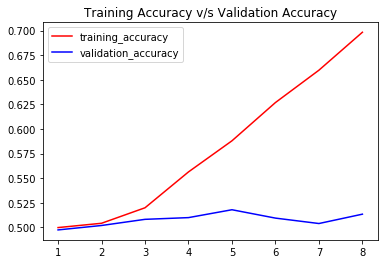

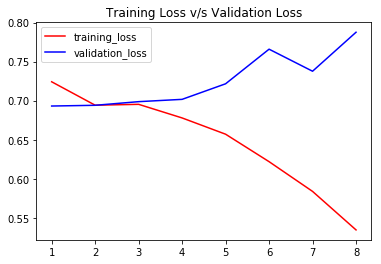

In [16]:
# Plots - pending
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

x_range = range(1,len(acc)+1)

plt.plot(x_range, acc, 'r-', label='training_accuracy')
plt.plot(x_range, val_acc, 'b-', label='validation_accuracy')
plt.legend()
plt.title('Training Accuracy v/s Validation Accuracy')
plt.show()


plt.plot(x_range, loss, 'r-', label='training_loss')
plt.plot(x_range, val_loss, 'b-', label='validation_loss')
plt.legend()
plt.title('Training Loss v/s Validation Loss')
plt.show()

In [17]:
# Model using self-learning Embedding Layer

learning_model = Sequential()
learning_model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
learning_model.add(Flatten())
learning_model.add(Dense(32,activation='relu'))
learning_model.add(Dense(1,activation='sigmoid'))
learning_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [18]:
learning_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = learning_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Train on 16000 samples, validate on 4000 samples
Epoch 1/8
16000/16000 [==============================] - 8s 497us/step - loss: 0.6935 - acc: 0.5059 - val_loss: 0.6929 - val_acc: 0.5058
Epoch 2/8
16000/16000 [==============================] - 8s 476us/step - loss: 0.4744 - acc: 0.8120 - val_loss: 0.8388 - val_acc: 0.5058
Epoch 3/8
16000/16000 [==============================] - 7s 460us/step - loss: 0.0960 - acc: 0.9750 - val_loss: 1.2138 - val_acc: 0.5080
Epoch 4/8
16000/16000 [==============================] - 8s 490us/step - loss: 0.0225 - acc: 0.9964 - val_loss: 1.4341 - val_acc: 0.5082
Epoch 5/8
16000/16000 [==============================] - 7s 468us/step - loss: 0.0105 - acc: 0.9978 - val_loss: 1.6739 - val_acc: 0.5052
Epoch 6/8
16000/16000 [==============================] - 7s 463us/step - loss: 0.0064 - acc: 0.9981 - val_loss: 1.8406 - val_acc: 0.5068
Epoch 7/8
16000/16000 [==============================] - 8s 481us/step - loss: 0.0041 - acc: 0.9982 - val_loss: 2.0295 - val_acc:

In [19]:
model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 2s 75us/step


[0.8455907570648193, 0.5128]

In [20]:
learning_model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 2s 63us/step


[5.377768509674072, 0.5002]